In [2]:
import csv
import pandas as pd
import copy
import numpy as np
from sklearn.metrics import accuracy_score

# Exploratory part

In [19]:
df_train = pd.read_csv('Dataset/radiometries_train.csv')
n_edman=9;n_ch=3;rad_mean=10000; #Params from simulation

One thing that can be explored from the data is that not all peptides seem to be present in the reads. To check that, lets analyze the true-id array:

True-id array max value: 566, and unique values: 206


<AxesSubplot:>

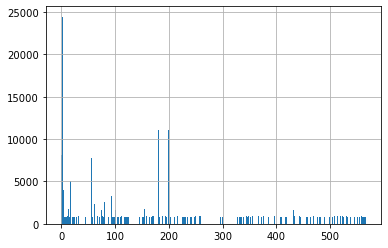

In [4]:
y_train=df_train["IDs"].to_numpy();
print("True-id array max value: "+str(np.max(y_train))+", and unique values: "+str(len(np.unique(y_train))))
df_train["IDs"].hist(bins=np.max(y_train))

We also observe a clear imbalance in the clases. This can be explained because of how the proteins are splitted, maybe some combinations are repeated more. Lets rename the IDS to make the classification between the possible values:

<AxesSubplot:>

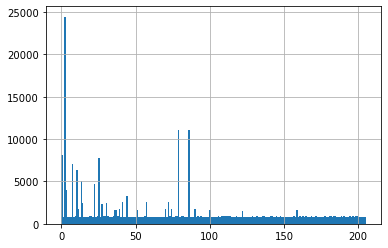

In [5]:
df_train_ynorm=df_train.copy()
labels=np.unique(y_train)
labels.sort()
df_train_ynorm['IDs'] = df_train_ynorm['IDs'].apply(lambda x: np.argwhere(labels==x)[0,0])
df_train_ynorm['IDs'].hist(bins=len(labels))

In [6]:
y_train_norm=df_train_ynorm["IDs"].to_numpy(); #Then we can obtain the prior probs given the train data.
unique, counts = np.unique(y_train_norm, return_counts=True)
prior_probs=counts/np.sum(counts);

In [55]:
# Dumb classifier
y_pred=np.random.choice(len(labels), len(y_train_norm), p=prior_probs);
print(accuracy_score(y_train_norm, y_pred))

0.017686892826540464


In [56]:
1/206

0.0048543689320388345

Given the prior probabilities, the random guessing with them is higher that without prior probs. 

In [57]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
X=df_train_ynorm.drop(columns=["IDs"]).to_numpy();
neigh.fit(X, y_train_norm);

In [58]:
Y_pred=neigh.predict(X);
print(accuracy_score(y_train_norm, Y_pred))

0.6853309423006699


It takes quite a lot of time, but 68% is quite better metric than random guessing.

# Comparing on test dataset

In [7]:
df_test = pd.read_csv('Dataset/radiometries_test.csv')
y_test=df_test["IDs"].to_numpy();
y_test_norm = [np.argwhere(labels==x)[0,0] for x in y_test]

In [8]:
df_test_ynorm=df_test.copy()
df_test_ynorm['IDs'] = y_test_norm

In [9]:
# Dumb classifier
y_pred=np.random.choice(len(labels), len(y_test_norm), p=prior_probs);
#y_pred=np.random.choice(len(label_values), len(true_labels_test));
print(accuracy_score(y_test_norm, y_pred))

0.017978988411133975


Performance decreases with the test set

In [62]:
X=df_test_ynorm.drop(columns=["IDs"]).to_numpy();
Y_pred=neigh.predict(X);
print(accuracy_score(y_test_norm, Y_pred))

0.5225820426730207


Thats a much better performance!

## Performance with hybrid model

In [63]:
pred_hybridHMM_test = pd.read_csv('Dataset/predictions_hybrid_test.csv')
pred_hybridHMM_test['best_pep_iz'] = pred_hybridHMM_test['best_pep_iz'].apply(lambda x: np.argwhere(labels==x)[0,0])
HMM_Hybrid_y_pred=pred_hybridHMM_test['best_pep_iz'].to_numpy();
print(accuracy_score(y_test_norm, HMM_Hybrid_y_pred))

0.6155095851835807


Better performance here!

# Dataframe representation modifier functions

In [11]:
def discretize(df):
    df_disc=df.copy()
    df_disc.iloc[:,:-1]=abs(np.rint((df_disc.iloc[:,:-1].to_numpy()/mean)))
    df_disc.iloc[:,:-1]=df_disc.iloc[:,:-1].astype(int)
    return df_disc;

def disc_diff(df_disc):
    temp=df_disc.iloc[:,:-1].to_numpy();
    temp_channels=np.hsplit(temp, n_ch)
    temp_channels_diff=[np.concatenate((temp_channels[i][:,0].reshape(-1,1),np.diff(temp_channels[i],axis=1)),axis=1) for i in range(n_ch)]
    array_train_ynorm_xint_diff=copy.deepcopy(temp_channels_diff[0]);
    for i in range(1,n_ch):
        array_train_ynorm_xint_diff=np.concatenate((array_train_ynorm_xint_diff,temp_channels_diff[i]),axis=1)
    df_disc_diff=df_disc.copy()
    df_disc_diff.iloc[:,:-1]=array_train_ynorm_xint_diff;
    return df_disc_diff


In [26]:
def normalize(df):
    df_norm=df.copy()
    array_norm_wo_label=df_norm.iloc[:,:-1].to_numpy();
    mean=np.mean(array_norm_wo_label);
    std=np.std(array_norm_wo_label)
    norm=[mean, std]
    df_norm.iloc[:,:-1] = (df_norm.iloc[:,:-1] - mean)/std;
    return df_norm,norm;
def apply_norm(df, norm):
    mean,std=norm;
    df_norm=df.copy()
    df_norm.iloc[:,:-1] = (df_norm.iloc[:,:-1] - mean)/std;
    return df_norm;

In [12]:
df_train_ynorm_disc_diff=disc_diff(discretize(df_train_ynorm))

In [13]:
df_test_ynorm_disc_diff=disc_diff(discretize(df_test_ynorm))

In [27]:
df_train_ynorm_xnorm,norm=normalize(df_train_ynorm)
df_test_ynorm_xnorm=apply_norm(df_test_ynorm, norm)

### Naive Bayes

In [16]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
X=df_train_ynorm_disc_diff.drop(columns=["IDs"]).to_numpy();
min_val=np.min(X)
X=X-min_val #min val is negative
clf.fit(X, y_train_norm)
Y_pred=clf.predict(X);
print(accuracy_score(y_train_norm, Y_pred))

0.5826153606976416


In [18]:
X_test=df_test_ynorm_disc_diff.drop(columns=["IDs"]).to_numpy();
X_test=X_test-min_val  #min val is negative
X_test[X_test<0]=0;
Y_pred=clf.predict(X_test);
print(accuracy_score(y_test_norm, Y_pred))

0.5798765298386224


### Neural networks

In [48]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Input, Embedding,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [46]:
def gen_train_and_valid(df,val_prop=0.15):
    X=df.drop(columns=["IDs"]).to_numpy();
    Y=df["IDs"].to_numpy();
    Y=to_categorical(Y)
    idxs=np.arange(len(df));
    np.random.shuffle(idxs)
    to_valid=int(len(df)*val_prop)
    X_valid=X[idxs[:to_valid],:];Y_valid=Y[idxs[:to_valid],:]
    X_train=X[idxs[to_valid:],:];Y_train=Y[idxs[to_valid:],:]
    
    return X_train,Y_train,X_valid,Y_valid

In [49]:
X_train,Y_train,X_valid,Y_valid=gen_train_and_valid(df_train_ynorm_xnorm)

In [50]:
np.shape(Y_valid)

(41488, 206)

In [65]:
model = Sequential()
model.add(Dense(500, input_shape=(n_ch*(1+n_edman),), activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(len(labels), activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='CategoricalCrossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=30, verbose=1, callbacks=[es],batch_size=128)
len(history.history['loss'])  # Only 4 epochs are run.

Epoch 1/30
1837/1837 [==============================] - 13s 7ms/step - loss: 2.5289 - accuracy: 0.4167 - val_loss: 1.9011 - val_accuracy: 0.5260
Epoch 2/30
1837/1837 [==============================] - 14s 7ms/step - loss: 1.8125 - accuracy: 0.5421 - val_loss: 1.7501 - val_accuracy: 0.5526
Epoch 3/30
1837/1837 [==============================] - 14s 7ms/step - loss: 1.7210 - accuracy: 0.5616 - val_loss: 1.6958 - val_accuracy: 0.5690
Epoch 4/30
1837/1837 [==============================] - 13s 7ms/step - loss: 1.6803 - accuracy: 0.5703 - val_loss: 1.6615 - val_accuracy: 0.5708
Epoch 5/30
1837/1837 [==============================] - 13s 7ms/step - loss: 1.6562 - accuracy: 0.5749 - val_loss: 1.6465 - val_accuracy: 0.5782
Epoch 6/30
1837/1837 [==============================] - 13s 7ms/step - loss: 1.6382 - accuracy: 0.5788 - val_loss: 1.6301 - val_accuracy: 0.5808
Epoch 7/30
1837/1837 [==============================] - 14s 8ms/step - loss: 1.6251 - accuracy: 0.5825 - val_loss: 1.6294 - val_ac

30

In [ ]:
model = Sequential()
model.add(Dense(500, input_shape=(n_ch*(1+n_edman),), activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(len(labels), activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='CategoricalCrossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=30, verbose=1, callbacks=[es],batch_size=32)
len(history.history['loss'])  # Only 4 epochs are run.

Epoch 1/30
7347/7347 [==============================] - 43s 6ms/step - loss: 2.1344 - accuracy: 0.4790 - val_loss: 1.7752 - val_accuracy: 0.5367
Epoch 2/30
7347/7347 [==============================] - 38s 5ms/step - loss: 1.7220 - accuracy: 0.5578 - val_loss: 1.6800 - val_accuracy: 0.5693
Epoch 3/30
7347/7347 [==============================] - 32s 4ms/step - loss: 1.6666 - accuracy: 0.5713 - val_loss: 1.6548 - val_accuracy: 0.5702
Epoch 4/30
7347/7347 [==============================] - 31s 4ms/step - loss: 1.6361 - accuracy: 0.5786 - val_loss: 1.6245 - val_accuracy: 0.5775
Epoch 5/30
7347/7347 [==============================] - 30s 4ms/step - loss: 1.6159 - accuracy: 0.5828 - val_loss: 1.6104 - val_accuracy: 0.5833
Epoch 6/30
7347/7347 [==============================] - 32s 4ms/step - loss: 1.5998 - accuracy: 0.5860 - val_loss: 1.5925 - val_accuracy: 0.5878
Epoch 7/30
7347/7347 [==============================] - 31s 4ms/step - loss: 1.5875 - accuracy: 0.5885 - val_loss: 1.5829 - val_ac

In [ ]:
# fit the keras model on the dataset
model.fit(X, y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

In [35]:
df_train_ynorm_xnorm.drop(columns=["IDs"]).to_numpy()[1,:]

array([-0.43897619, -0.42296548, -0.4406083 , -0.42915869, -0.43217446,
       -0.43491577, -0.43834406, -0.43590736, -0.430687  , -0.43982998,
       -0.43707701, -0.42540508, -0.43168845, -0.42838003, -0.43203252,
       -0.42643362, -0.42425763, -0.43581612, -0.4199039 , -0.42882996,
        0.46412669,  0.44038812,  0.82191484, -0.42802359, -0.43797861,
       -0.43824559, -0.44593789, -0.42367215, -0.4240252 , -0.43237804])